In [1]:
import numpy as np; import pandas as pd;
import MetaTrader5 as mt5;                                               #Biblioteca do MetaTrader (para importar dados)
from pytz import timezone; from datetime import datetime, timedelta;        #Bibliotecas para lidar com datas
from ta.trend import EMAIndicator; from ta.volatility import BollingerBands #Indicadores análise técnica

def inicializa(Ativo, Ano,Mes,Dia,QtdeBar,TimeFrame):
    Fuso = timezone("America/Sao_Paulo")                                      #Definir fuso horário
    try:
        mt5.initialize();                                                     #Inicia conexão com o MetaTrader
        utc_from = datetime(Ano, Mes, Dia, tzinfo=Fuso)                       #Define formato da data    
        barsAtivo = mt5.copy_rates_from(Ativo, TimeFrame, utc_from, QtdeBar); #Define parâmetros
        mt5.shutdown()                                                        #Termina conexão com o MetaTrader
        return barsAtivo
    except Exception as e: raise e
        
def prepareData(Ativo, Ano,Mes,Dia, QtdeBar, TimeFrame):  
    try:
        barsAtivo = inicializa(Ativo,Ano,Mes,Dia, QtdeBar, TimeFrame);  #Importa as informações
        df = pd.DataFrame(data=barsAtivo);                              #Cria o DataFrame (Pandas)
        df['date'] = pd.to_datetime(df.time,  unit='s', origin='unix'); #Define o formato dos dados da coluna 'date'
        df.rename(columns = {'time':'date'}, inplace = True);           #Substitui a coluna 'time' por 'date'
        df.set_index('date',inplace=True);                              #Define 'date' como índice (ordenação do DataFrame)
        df.sort_index(ascending=False, inplace=True)                    #Ordena o índice pela data
    except Exception as e: raise e
    df.symbol = Ativo
    return df

def criterio():                                                         #Define o critério de "boa ação para compra"
    global compras, c2, c3, novo_topo, topo_ant, novo_fundo, fundo_ant
    for j in range(len(df)):                                            #Executar em TODO o DataFrame
        
        rr = len(df)-1-j                                               
        #Comando para ler o DataFrame "do mais antigo para o mais recente" (barras em ordem cronológica)
        
        if (df['close'][rr]-df['open'][rr])/df['open'][rr]>0.04:        #Identifica "saltos" (barras muito grandes)  
            c2=1   
        if c3 == 7: c3=0; c2=0                                          #Zera contador
        #Existe um contador para que não sejam compradas ações logo após saltos ou martelos invertidos
        
        if (j>5 and (df['high'][rr+4]<df['close'][rr] and
                    df['high'][rr+3]<df['close'][rr] and
                    df['high'][rr+2]<df['close'][rr] and
                    df['high'][rr+1]<df['close'][rr] and
                    df['close'][rr]>df['close'][rr+1])):                #Define topo
            topo_ant = novo_topo;
            novo_topo = df['high'][rr+1];
            
        if (j>5 and (df['low'][rr+4]>df['low'][rr+2] and
                    df['low'][rr+3]>df['low'][rr+2] and
                    df['low'][rr]>df['low'][rr+2] and
                    df['low'][rr+1]>df['low'][rr+2])):                 #Define fundo
            fundo_ant = novo_fundo;
            novo_fundo = df['low'][rr+1];
            
        if (df['close'][rr] < (df['high'][rr] - df['low'][rr])*0.45 + df['low'][rr]  #Identifica martelos invertidos
            and df['close'][rr] > df['BBup'][rr]):                    #Fechamento > BandaBollinger superior
            c2=1
            
        c3+=1
    if (df['close'][0]>novo_topo and                                  #Valor atual > último topo
        novo_fundo>=fundo_ant and                                     #Topos acendentes
        df['close'][0]<df['close'][len(df)-1] and                     #Valor atual < valor no início da série
        (df['close'][1]-df['open'][1])/df['open'][1]<0.04 and         #Barra não é muito grande
        c2==0):
        
        print('\''+acoes[i]+'\'',end=','); compras.append(acoes[i])   #Imprime "ação boa"

In [2]:
_Dia = 31; _Mes = 12; _Ano  = 2022; _QtdeBar = 250;                   #Sempre colocar data futura
c3=0; c2=0; novo_topo=0; topo_ant = 0; novo_fundo =0; fundo_ant = 0
compras=[];

acoes = ['ABCB4','ABEV3','AERI3','AGRO3','ALPA4','ALPK3','ALSO3','AMAR3','AMBP3','AMER3','ANIM3','APER3',
         'ARZZ3','ASAI3','ATOM3','AZEV4','AZUL4','B3SA3','BBAS3','BBDC3','BBDC4','BBRK3','BBSE3','BEEF3',
         'BEES3','BIDI3','BIDI4','BKBR3','BMOB3','BOAS3','BPAN4','BRAP4','BRDT3','BRFS3','BRKM5','BRML3',
         'BRPR3','CAML3','CASH3','CCPR3','CCRO3','CEAB3','CGRA4','CIEL3','CMIG3','CMIG4','CMIN3','COGN3',
         'CPLE3','CRFB3','CSAN3','CSMG3','CSNA3','CVCB3','CYRE3','DIRR3','DTEX3','EALT4','ECOR3','EGIE3',
         'ELET3','EMBR3','ENAT3','ENBR3','ENEV3','ENGI4','ENJU3','EQTL3','ETER3','EUCA3','FESA4','FHER3',
         'FLRY3','GFSA3','GGBR3','GGBR4','GNDI3','GOAU3','GOAU4','GOLL4','GRND3','GUAR3','HAPV3','HBOR3',
         'HGTX3','HYPE3','IGTA3','IRBR3','ITSA4','ITUB3','ITUB4','JBSS3','JHSF3','JPSA3','JSLG3','KLBN4',
         'LAME3','LAME4','LAVV3','LCAM3','LEVE3','LINX3','LJQQ3','LOGN3','LPSB3','LREN3','LWSA3','MDIA3',
         'MEAL3','MGLU3','MILS3','MOVI3','MRFG3','MRVE3','MULT3','NEOE3','NTCO3','OIBR3','PCAR3','PETR3',
         'PETR4','PETZ3','PGMN3','POMO4','POSI3','PRIO3','PSSA3','PTBL3','QUAL3','RADL3','RAIL3','RAPT4',
         'RDNI3','RECV3','RENT3','ROMI3','SANB3','SANB4','SAPR3','SAPR4','SBSP3','SEER3','SEQL3','SHOW3',
         'SIMH3','SLCE3','SMLS3','SMTO3','SOJA3','SOMA3','STBP3','SUZB3','TASA3','TASA4','TCSA3','TECN3',
         'TESA3','TIMS3','TOTS3','TRPL4','UGPA3','USIM5','VALE3','VIVA3','VIVT4','VULC3','VVAR3','WEGE3',
         'WIZS3','YDUQ3']

for i in range(len(acoes)):
    try:
        _Ativo = acoes[i]; _TimeFrame=mt5.TIMEFRAME_D1;                          #Ordenar tempo das barras em "1D"
        _Df_Ativo = prepareData(_Ativo,_Ano,_Mes,_Dia,_QtdeBar,_TimeFrame)       #DataFrame dos dados importados
        
        df = _Df_Ativo.reset_index().iloc[::-1];                                 #DataFrame auxiliar
        #Como os dados do MetaTrader são colocados "do mais recente ao mais antigo" e os indicadores
        #técnicos são aplicados "do mais antigo para o mais recente", é necessário inverter a ordem do DataFrame

        BBup = BollingerBands(df['close'], 20, 1.5); df['BBup'] = BBup.bollinger_hband();
        #Cria uma coluna com os valores da banda de bollinger ordenada pelo fechamento com 20 períodos
        #e desvio padrão de 1.5
        
        mask=df.isnull(); df=df.dropna()                                        #Retira valores nulos do DataFrame
        criterio()                                                              #Aplica o critério definido
    except: print('\nerro em:',acoes[i])
        
print('\n',len(compras),' ações hoje cumprem os requisitos que você pediu',sep='')

'LCAM3','LEVE3','NEOE3','SAPR4','SUZB3',
5 ações hoje cumprem os requisitos que você pediu


In [3]:
dados=pd.DataFrame(); SHSH=pd.DataFrame();
for i in range(len(compras)):
    _Ativo=compras[i];
    _TimeFrame=mt5.TIMEFRAME_D1;
    _Df_Ativo=prepareData(_Ativo,_Ano,_Mes,_Dia,_QtdeBar,_TimeFrame)
    df = _Df_Ativo.reset_index().iloc[::-1];
    mask=df.isnull(); df=df.dropna()
    
    SHSH = df['close'];
    SHSH2 = pd.concat([df['close']],axis=1);
    SHSH2=SHSH2.rename({'close':compras[i]},axis=1);
    
    if i==0: dados=SHSH2;
    else: dados = pd.concat([dados,SHSH2],axis=1);
dados

#Cria um DataFrame concatenando os valores de fechamento das ações aprovadas no critério

,LCAM3,LEVE3,NEOE3,SAPR4,SUZB3
249,27.18,38.83,15.57,3.81,51.45
248,27.85,37.85,15.46,3.77,50.44
247,27.90,35.89,15.78,3.82,48.34
246,27.31,35.90,15.28,3.77,48.88
245,28.88,34.20,15.35,3.71,49.36
...,...,...,...,...,...
4,23.72,25.20,16.10,3.67,49.68
3,23.66,25.33,16.25,3.68,49.07
2,23.70,25.75,16.38,3.65,49.52
1,23.53,25.92,16.45,3.70,49.98


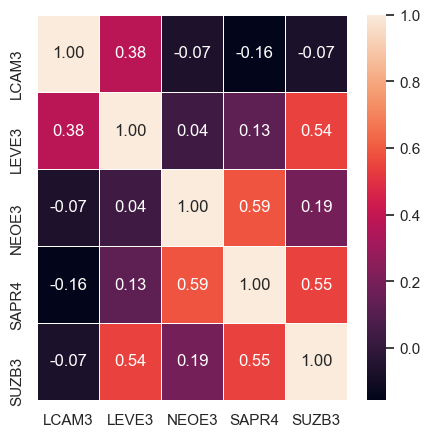

In [4]:
import seaborn as sn; import matplotlib.pyplot as plt

sn.set(rc={'figure.figsize':(5,5)})
cr = dados.corr()
sn.heatmap(cr, annot = True, fmt=".2f", linewidths=.6)
plt.show()

#Gráfico de correlação das ações definidas como boas